# 资产组合构建

## 本段代码利用quantOS系统进行资产分析及组合构建，比较了指数权重、等权重和波动率倒
## 数加权法三种股票组合构建方法

## 系统设置

In [49]:
# encoding: utf-8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import matplotlib.mlab as mlab
import scipy.stats as stats
from matplotlib.ticker import Formatter

sns.set_style('darkgrid')
sns.set_context('poster')
%matplotlib inline

In [2]:
from jaqs.data import RemoteDataService
import jaqs.util as jutil
from __future__ import print_function, unicode_literals, division, absolute_import

from jaqs.data import RemoteDataService, DataView

In [3]:
dataview_dir_path = '.'
backtest_result_dir_path = '.'

import os
phone = os.environ.get('QUANTOS_USER')
token = os.environ.get('QUANTOS_TOKEN')

data_config = {
  "remote.data.address": "tcp://data.quantos.org:8910",
  "remote.data.username": phone,
  "timeout": 3600,
  "remote.data.password": token
}

ds = RemoteDataService()
ds.init_from_config(data_config)


Begin: DataApi login 17321165656@tcp://data.quantos.org:8910
    login success 



'0,'

## 设置参数

In [4]:
START_DATE, END_DATE = 20140101, 20180420
UNIVERSE = '000905.SH'

## 准备DataView

In [5]:
dataview_props = {# Start and end date of back-test
                  'start_date': START_DATE, 'end_date': END_DATE,
                  # Investment universe and performance benchmark
                  'universe': UNIVERSE, 'benchmark': UNIVERSE,
                  # Data fields that we need
                  'fields': 'free_share,total_share,float_share,float_mv,sw1',
                  # freq = 1 means we use daily data. Please do not change this.
                  'freq': 1}

# DataView utilizes RemoteDataService to get various data and store them
dv = DataView()
dv.init_from_config(dataview_props, ds)
dv.prepare_data()

Initialize config success.
Query data...
Query data - query...
NOTE: price adjust method is [post adjust]
112
225
338
451
564
677
790
903
1016
112
225
338
451
564
677
790
903
1016
21
43
65
87
109
131
153
175
197
219
241
263
285
307
329
351
373
395
417
439
461
483
505
527
549
571
593
615
637
659
681
703
725
747
769
791
813
835
857
879
901
923
945
967
989
1011
1033
1055
1077
    At fields 
Query data - daily fields prepared.
Query instrument info...
Query adj_factor...
Query benchmark...
Query benchmar member info...
Query groups (industry)...
Data has been successfully prepared.


## 计算个股日收益率

In [6]:
dv.add_formula('daily_ret', 'Return(close_adj, 1)', is_quarterly = False)
daily_ret = dv.get_ts('daily_ret', start_date=dv.extended_start_date_d)

In [7]:
index_member = dv.get_ts('index_member', start_date=dv.extended_start_date_d)
index_member = index_member.astype('bool')

In [8]:
daily_ret = daily_ret[index_member]
# daily_ret = daily_ret.fillna(0)

## 计算指数日收益率

In [9]:
index_ret = dv.data_benchmark.pct_change()
index_ret.columns = ['index_ret']
index_ret = index_ret.fillna(0)

## 计算指数周收益率

In [10]:
index_ret_copy = index_ret.copy()

In [11]:
index_ret_copy += 1
index_ret_copy = np.log(index_ret_copy)
index_ret_copy['trade_date'] = index_ret_copy.index
index_ret_copy['NoWeek'] = index_ret_copy['trade_date'].apply(lambda x: str(datetime.datetime.strptime(str(x), '%Y%m%d').date().isocalendar()[1]))
index_ret_copy['NoWeek'] = index_ret_copy['NoWeek'].apply(lambda x: '0' + x if len(x) == 1 else x)
index_ret_copy['year'] = index_ret_copy['trade_date'].apply(lambda x: str(x)[:4])
index_ret_copy['year-week'] = index_ret_copy['year'] + '-'+ index_ret_copy['NoWeek']
del index_ret_copy['NoWeek'], index_ret_copy['year']
weekly_index_ret = index_ret_copy.groupby('year-week').sum()
del weekly_index_ret['trade_date']
weekly_index_ret = np.exp(weekly_index_ret) - 1

## 计算个股周收益率

In [12]:
daily_ret_copy = daily_ret.copy()

In [13]:
daily_ret_copy += 1
daily_ret_copy = np.log(daily_ret_copy)
daily_ret_copy['trade_date'] = daily_ret_copy.index
daily_ret_copy['NoWeek'] = daily_ret_copy['trade_date'].apply(lambda x: str(datetime.datetime.strptime(str(x), '%Y%m%d').date().isocalendar()[1]))
daily_ret_copy['NoWeek'] = daily_ret_copy['NoWeek'].apply(lambda x: '0' + x if len(x) == 1 else x)
daily_ret_copy['year'] = daily_ret_copy['trade_date'].apply(lambda x: str(x)[:4])
daily_ret_copy['year-week'] = daily_ret_copy['year'] + '-'+ daily_ret_copy['NoWeek']
del daily_ret_copy['NoWeek'], daily_ret_copy['year']
week_day_convert = daily_ret_copy.groupby('year-week')['trade_date'].last()
weekly_ret = daily_ret_copy.groupby('year-week').sum()
del weekly_ret['trade_date']
weekly_ret = np.exp(weekly_ret) - 1

In [14]:
weekly_ret = pd.concat([week_day_convert, weekly_ret], axis = 1)

In [15]:
weekly_ret = weekly_ret.set_index('trade_date')

## 等权重组合

In [17]:
weekly_ret = weekly_ret[index_member]

In [18]:
ew_ret = pd.DataFrame(weekly_ret.mean(axis = 1))
ew_ret.columns = ['ew_ret']

## 个股历史波动率倒数加权组合

In [19]:
# 计算个股30天moving window波动率
vol_ret = pd.rolling_std(daily_ret, 100)
dv.append_df(vol_ret, 'volatility_ret', is_quarterly = False)
dv.add_formula('cutoff_volatility_ret', 'Cutoff(volatility_ret)', is_quarterly=False)
vol_ret_cutoff = dv.get_ts('cutoff_volatility_ret', start_date=dv.extended_start_date_d)

C:\Users\lli\AppData\Local\QuantosFinanceTerminal\python\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100,center=False).std()
  
C:\Users\lli\AppData\Local\QuantosFinanceTerminal\python\lib\site-packages\numpy\lib\nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\lli\AppData\Local\QuantosFinanceTerminal\python\lib\site-packages\jaqs\data\py_expression_eval.py:942: RuntimeWarning: invalid value encountered in greater
  mask = diff_abs > z_score * mad
C:\Users\lli\AppData\Local\QuantosFinanceTerminal\python\lib\site-packages\jaqs\data\py_expression_eval.py:944: RuntimeWarning: invalid value encountered in sign
  x = x + z_score * mad * np.sign(diff * mask) + mask * median


In [37]:
new_start_date = daily_ret.index[101]

In [20]:
vol_ret_cutoff = vol_ret_cutoff.replace(0.0, np.nan)
reverse_vol_ret = 1.0/vol_ret_cutoff
reverse_vol_ret = reverse_vol_ret.fillna(0)
reverse_vol_ret = reverse_vol_ret.replace(np.inf, 0)

In [21]:
reverse_vol_ret_weight = reverse_vol_ret.div(reverse_vol_ret.sum(axis = 1), axis = 0)

In [22]:
reverse_vol_ret_weight_weekly = reverse_vol_ret_weight.loc[weekly_ret.index]

In [25]:
reverse_vol_weekly_ret = pd.DataFrame(reverse_vol_ret_weight_weekly.mul(weekly_ret).sum(axis = 1))
reverse_vol_weekly_ret.columns = ['reverse_vol_ret']
reverse_vol_weekly_ret = reverse_vol_weekly_ret.loc[new_start_date:]

## 比较三组组合方式

In [26]:
weekly_index_ret = pd.concat([week_day_convert, weekly_index_ret], axis = 1)

In [27]:
weekly_index_ret = weekly_index_ret.set_index('trade_date')

In [28]:
weekly_index_ret = weekly_index_ret.loc[new_start_date:]

In [29]:
ew_ret = ew_ret.loc[new_start_date:]

In [30]:
ret_compare = pd.concat([weekly_index_ret, ew_ret, reverse_vol_weekly_ret], axis = 1)

In [40]:
print("三种组合方式年化收益率：")
print(ret_compare.mean()*52)

三种组合方式年化收益率：
index_ret          0.154131
ew_ret             0.194628
reverse_vol_ret    0.177556
dtype: float64


In [41]:
print("三种组合方式年化波动率：")
print(ret_compare.std()*np.sqrt(52))

三种组合方式年化波动率：
index_ret          0.294566
ew_ret             0.301420
reverse_vol_ret    0.286570
dtype: float64


In [42]:
print("三种组合方式年化Sharpe Ratio：")
print(ret_compare.mean()/ret_compare.std()*np.sqrt(52))

三种组合方式年化Sharpe Ratio：
index_ret          0.523247
ew_ret             0.645703
reverse_vol_ret    0.619591
dtype: float64


In [44]:
cum_ret_compare = (ret_compare + 1).cumprod()

In [50]:
class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%Y%m'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        """Return the label for time x at position pos"""
        ind = int(np.round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''

        # return self.dates[ind].strftime(self.fmt)
        return pd.to_datetime(self.dates[ind], format="%Y%m%d").strftime(self.fmt)

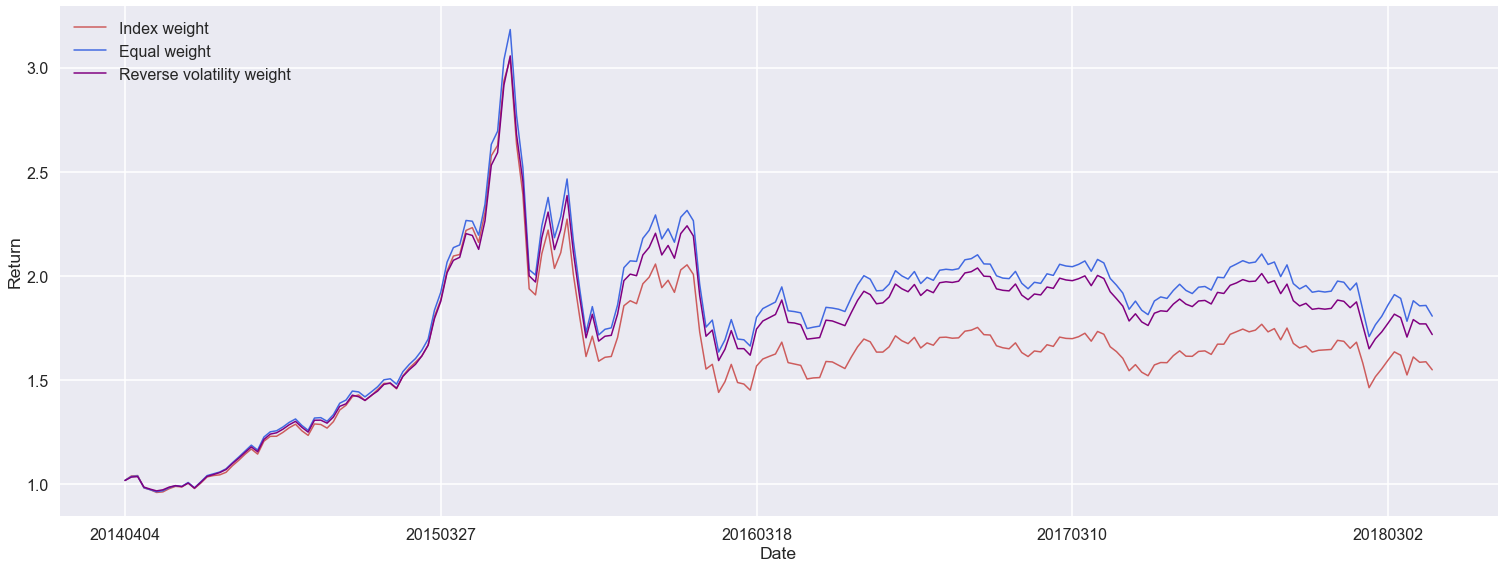

In [52]:
fig, ax1 = plt.subplots(1, 1, figsize=(21, 8))

idx0 = cum_ret_compare.index
idx = range(len(idx0))

ax1.plot(idx, cum_ret_compare.index_ret, lw=1.5, color='indianred', label='Index weight')
ax1.plot(idx, cum_ret_compare.ew_ret, lw=1.5, color='royalblue', label='Equal weight')
ax1.plot(idx, cum_ret_compare.reverse_vol_ret, lw=1.5, color='purple', label='Reverse volatility weight')

# ax1.axhline(0.0, color='k', lw=0.5, ls='--')

ax1.legend(loc='upper left')
ax1.set_xlabel("Date")
ax1.set_ylabel("Return")
ax1.xaxis.set_major_formatter(MyFormatter(idx0, '%Y%m%d'))

plt.tight_layout()
# fig.savefig('lgt_brinson_cum.png')
# plt.close()